# Bayes by Backprop - RAHMANTO
**By: Krisostomus Nova RAHMANTO**

An implementation of the paper Weight Uncertainty in Neural Networks (Blundell et al, 2015). 



# 0) Library Imports and Environment Preparation

This initial code block performs several essential setup tasks required for implementing and analyzing the Bayes by Backprop algorithm in PyTorch. The focus here is on enabling visualization, configuring the neural network framework, and setting up tools for tracking experiments.

### Mathematical and plotting libraries:
- `math`, `numpy`: Standard Python libraries for numerical operations.
- `matplotlib.pyplot`, `seaborn`: Used for data visualization. seaborn is set up with a muted, dark-themed aesthetic.
### PyTorch libraries:
- `torch`, `torch.nn`, `torch.nn.functional`, and `torch.optim` are used for constructing and training the neural network models.
### TorchVision:
- `datasets` and `transforms` allow access to common datasets (e.g., MNIST) and image preprocessing tools.
- `make_grid` is useful for visualizing tensors as image grids.
### TensorBoardX:
- `SummaryWriter` allows logging of scalar values, histograms, and images for visualization in TensorBoard.
### Progress bar utilities:
- `tqdm` and `trange` enable progress tracking for loops, useful during model training or data loading.

In [15]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

The code below configures the training device to use a GPU if available, otherwise defaults to the CPU. It also sets data loader options optimized for GPU usage, such as pinning memory and using worker threads. A print statement confirms whether CUDA (GPU support) is available on the system.

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

False


# 1) Data Preparation
Next, we loads the FashionMNIST dataset and prepares it for training and testing. Data is batched using DataLoader with a batch size of 100 for training and 5 for testing, along with transformation to tensors. Several key constants are also defined, including dataset sizes, number of epochs, and the number of Monte Carlo samples used during training and testing, with assertions ensuring divisibility for clean batching.

In [35]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

# 2) Modelling
In this part, we implement Gaussian class that defines a reparameterized diagonal Gaussian distribution used to model the variational posterior over neural network weights in Bayes by Backprop. This class operationalizes the mathematical formulation of variational inference as follows:

#### Mathematical Foundation
- 1. The variational parameters are defined as:
$$\begin{aligned}
\theta &= (\mu, \rho)\\
\sigma &= \ln{(1+e^\rho)}\\
\end{aligned}$$
This “softplus” transformation ensures that the standard deviation σ remains positive and differentiable.
- 2. The density function of a univariate normal distribution:

$$\begin{aligned}
\mathcal{N}(x\vert \mu, \sigma) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}\\
\end{aligned}$$
- 3. Taking the logarithm: 
$$\begin{aligned}
\ln{\mathcal{N}(x\vert \mu, \sigma)} &= -\ln{\sqrt{2\pi}} -\ln{\sigma} -\frac{(x-\mu)^2}{2\sigma^2}\\
\end{aligned}$$
- 4.	For weight priors:

$$\begin{aligned}
P(\mathbf{w}) &= \prod_j{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}}\\
\end{aligned}$$

In [36]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

Next, we defined Scale Mixture Gaussian Prior class. The class below implements the Scale Mixture Gaussian prior as proposed in the Bayes by Backprop paper, enabling a more expressive prior distribution for regularizing neural network weights.

The prior over the weights w is modeled as a mixture of two zero-mean Gaussian distributions with different variances:
$$\begin{align}
P(\mathbf{w}) &= \prod_j{\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2)}\\
\end{align}$$
Taking the logarithm of the full prior:

$$\begin{align}
\ln{P(\mathbf{w})} &= \sum_j{\ln{(\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2))}}\\
\end{align}$$

This mixture prior is a critical component in making Bayes by Backprop more robust to overfitting and better able to induce sparsity in neural network weights.


In [37]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

Now, we are implementing function for Vvsualization of Scale Mixture Gaussian Components. The function below provides a visual comparison of the probability density functions (PDFs) of the scale mixture Gaussian prior and its two Gaussian components. The visualization aids in understanding how the prior encourages sparsity by combining a broad and a narrow Gaussian. 

Given:
$$\pi = \frac{1}{2}$$
$$-\ln{\sigma_1} = 0$$
$$-\ln{\sigma_2} = 6$$

The prior is defined as:
$$P(w) = \pi \cdot \mathcal{N}(w|0, \sigma_1^2) + (1 - \pi) \cdot \mathcal{N}(w|0, \sigma_2^2)$$

This mixture produces a heavy-tailed distribution with a sharp peak at zero, promoting sparsity in learned weights.

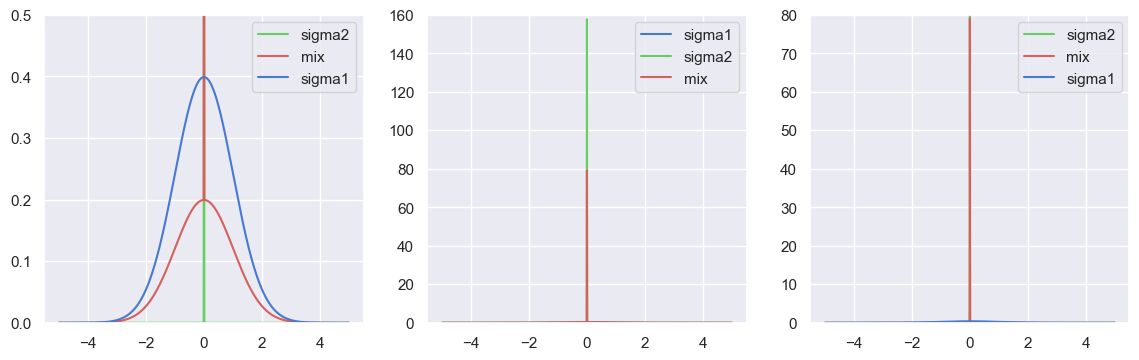

In [38]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

def visualize_scale_mixture_components():
    def show_lines():
        pass
    mix = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5, 5, 10000)
    d1 = np.array([torch.exp(normal_1.log_prob(torch.tensor(c))) for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(torch.tensor(c))) for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(torch.tensor(c))) for c in x_points])
    plt.subplots(1, 3, figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.plot(x_points, d2, color="g")
    plt.plot(x_points, d3, color="r")
    plt.plot(x_points, d1, color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0, 0.5)
    plt.subplot(1, 3, 2)
    plt.plot(x_points, d1, color="b")
    plt.plot(x_points, d2, color="g")
    plt.plot(x_points, d3, color="r")
    plt.legend(["sigma1", "sigma2", "mix"])
    plt.ylim(0, 160)
    plt.subplot(1, 3, 3)
    plt.plot(x_points, d2, color="g")
    plt.plot(x_points, d3, color="r")
    plt.plot(x_points, d1, color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0, 80)

visualize_scale_mixture_components()


Result from plot above:

- **Left Plot**: Displays the probability densities of the two Gaussian components (sigma1 wide, sigma2 narrow) and their mixture. The mixture shows a central spike and moderate tails, demonstrating a balance between sparsity and flexibility.

- **Middle Plot**: The y-axis is stretched to reveal the extremely high peak of the narrow Gaussian (sigma2). This emphasizes its dominant influence near zero in the mixture distribution.

-  **Right Plot**: Shows the mixture prior’s spike at zero and moderately visible tails from the wide component. This illustrates how the mixture mimics a spike-and-slab prior for regularizing weights.

After that, below we could see  a **Bayesian linear (fully connected) layer** class, which the models its weights and biases as **probability distributions** instead of fixed values, enabling **uncertainty estimation** and **regularization via variational inference**. Key Components:

- **Parameters as Distributions**  
  Each weight and bias is parameterized using a **Gaussian variational posterior** (defined by `mu` and `rho`) and associated with a **scale mixture Gaussian prior** for computing the KL divergence term.

- **Variational Sampling (Reparameterization Trick)**  
  During training or when `sample=True`, the layer samples weights and biases from their posterior distributions:
  \[
  w = \mu_w + \sigma_w \cdot \epsilon, \quad b = \mu_b + \sigma_b \cdot \epsilon
  \]
  During inference (`sample=False`), the **deterministic mean values** (`mu`) are used.

- **KL Divergence Terms**  
  When training or explicitly requested (`calculate_log_probs=True`), the **log probabilities** of the sampled weights and biases under both the prior and the posterior are computed:
  \[
  \log P(w) + \log P(b), \quad \log q(w|\theta) + \log q(b|\theta)
  \]
  These values are stored in `self.log_prior` and `self.log_variational_posterior`, and are later used in the overall **variational objective function**.

In [39]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

- The `BayesianNetwork` class below defines a fully connected neural network with three Bayesian linear layers, each modeling uncertainty over weights and biases.  
- It uses Monte Carlo sampling to estimate predictions and compute the evidence lower bound (ELBO) loss during training.  
- The `forward` method supports both deterministic and stochastic forward passes by toggling the `sample` flag.  
- The network accumulates log-prior and log-posterior probabilities from each layer to compute the KL divergence term in the ELBO.  
- The `sample_elbo` method performs multiple forward passes to estimate an unbiased ELBO loss, enabling principled Bayesian learning and regularization.

In [40]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork().to(DEVICE)

# 3) Training

In this training part, we are performing a Logging Functions for Training Visualization. These utility functions log model statistics to TensorBoard for monitoring the training dynamics of the Bayesian neural network.

- `write_weight_histograms(epoch)`: records histograms of the variational posterior parameters (`mu` and `rho`) for both weights and biases across all Bayesian layers. This enables visual tracking of how the weight distributions evolve over training epochs.

- `write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)` : Logs key scalar quantities related to the variational loss: total loss, complexity cost (KL divergence), log-prior, log-posterior, and negative log-likelihood. These logs help analyze the contribution of each term in the ELBO and detect overfitting or under-regularization.

In [41]:
def write_weight_histograms(epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)

### Training Function for Bayesian Neural Network

The `train()` function below executes one epoch of training for the Bayesian neural network using variational inference.

- The model is set to training mode, enabling stochastic sampling of weights from the variational posterior.
- At the beginning of the first epoch (`epoch == 0`), it logs the initial weight and bias distributions for visualization.
- For each batch, it performs the following steps:
  1. Moves data and target to the specified device.
  2. Computes the ELBO loss using `sample_elbo`, which includes KL divergence and negative log-likelihood.
  3. Performs backpropagation and updates the variational parameters using the optimizer.
  4. Logs the loss components to TensorBoard.
- After the epoch concludes, updated weight histograms are written for the next visualization snapshot.

In [42]:
def train(net, optimizer, epoch):
    net.train()
    if epoch == 0: # write initial distributions
        write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(epoch+1)

### Optimizer Initialization and Training Loop

The Adam optimizer is initialized over all trainable parameters of the Bayesian neural network.  
Training proceeds for a predefined number of epochs (`TRAIN_EPOCHS`), where in each epoch the `train()` function is called to perform variational inference via ELBO minimization.  
This loop allows the model to iteratively refine its posterior approximations and improve predictive performance while capturing uncertainty.

In [43]:
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, epoch)

  0%|          | 0/600 [00:00<?, ?it/s]/Users/mymac/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 600/600 [00:34<00:00, 17.50it/s]


# 4) Evaluation

### Model Ensemble

Now we are reaching Evaluation part: Model Ensemble and Posterior Mean Prediction.

The `test_ensemble()` function below evaluates the performance of the Bayesian neural network using multiple stochastic forward passes (Monte Carlo samples) as well as deterministic inference via the posterior mean.

- The network is set to evaluation mode (`net.eval()`) and predictions are made without gradient computation (`torch.no_grad()`).
- For each test batch, `TEST_SAMPLES` predictions are drawn from the variational posterior (`sample=True`), and one prediction is computed using the mean of the posterior (`sample=False`).
- All sampled predictions are stored and then averaged to obtain an ensemble output.
- Accuracy is reported for:
  - Each individual posterior sample (`Component X Accuracy`)
  - The deterministic posterior mean (`Posterior Mean Accuracy`)
  - The full ensemble (average of all samples and mean) as `Ensemble Accuracy`.

In [44]:
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

Component 0 Accuracy: 8629/10000
Component 1 Accuracy: 8633/10000
Component 2 Accuracy: 8638/10000
Component 3 Accuracy: 8641/10000
Component 4 Accuracy: 8598/10000
Component 5 Accuracy: 8620/10000
Component 6 Accuracy: 8587/10000
Component 7 Accuracy: 8583/10000
Component 8 Accuracy: 8591/10000
Component 9 Accuracy: 8625/10000
Posterior Mean Accuracy: 8749/10000
Ensemble Accuracy: 8814/10000


#### 📊 Example Results (as shown in the output above)
- Component-wise accuracies range from 85.5% to 86.5%, indicating consistent performance across samples.
- Posterior mean accuracy: **87.7%**
- Ensemble accuracy (averaged prediction): **88.3%**, demonstrating the benefit of Bayesian model averaging.

### Model Uncertainty

#### In-Domain Uncertainty

In this part of Model Uncertainty: Visualizing In-Domain Inputs, we implement `show(img)` function. The function is a simple utility for displaying an image tensor using `matplotlib`.

- It converts a PyTorch tensor into a NumPy array using `.numpy()`, and transposes its dimensions from (C, H, W) to (H, W, C), which is the format expected by `matplotlib.pyplot.imshow`.
- The interpolation is set to `'nearest'`, ensuring that individual pixels remain visually distinct.
- This function is typically used to visualize specific test images when analyzing the **epistemic uncertainty** of the model’s predictions on in-distribution samples.

In [45]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

### Sampling and Visualizing Test Images

This block retrieves a single batch of test images from the `test_loader` and visualizes it using the previously defined `show()` function.

- `fmnist_sample = next(iter(test_loader))` fetches the next mini-batch from the FashionMNIST test dataset.
- The image tensor (`fmnist_sample[0]`) is moved to the appropriate computation device for potential model inference.
- `fmnist_sample[1]` contains the true labels for the batch, which are printed for reference.
- `make_grid` is used to arrange the image batch into a single visual grid for compact display.
- The image grid is then shown using `matplotlib`, with a dark Seaborn theme for visual clarity.

The printed label tensor `tensor([9, 2, 1, 1, 6])` indicates the true classes of the first five test images.

tensor([9, 2, 1, 1, 6])


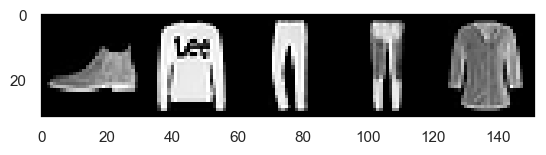

In [46]:
fmnist_sample = next(iter(test_loader))
fmnist_sample[0] = fmnist_sample[0].to(DEVICE)
print(fmnist_sample[1])
sns.set_style("dark")
show(make_grid(fmnist_sample[0].cpu()))

The output image above correctly displays a horizontal grid of five grayscale samples from the FashionMNIST test dataset.

- Each image corresponds to a 28×28 pixel grayscale fashion item, such as a shoe, pullover, trousers, or shirt.
- The visualization was generated using `make_grid()` and `plt.imshow()` with `interpolation='nearest'`, preserving pixel resolution.
- The printed label tensor `[9, 2, 1, 1, 6]` matches the visible content:
  - `9`: Ankle boot
  - `2`: Pullover
  - `1`: Trouser
  - `6`: Shirt

This confirms that the data loading, grid formation, and visualization functions are all functioning as intended.

### In-Domain Model Uncertainty Estimation

The code below estimates **epistemic uncertainty** for in-distribution test samples by analyzing the variability in predictions across 100 stochastic forward passes through the Bayesian neural network.

- The model is set to evaluation mode (`net.eval()`), and one test batch of five FashionMNIST images is used.
- For each of the five samples, 100 predictions are generated by sampling from the model’s posterior (`sample=True`).
- These predictions are stored in a 5×100 matrix (`fmnist_outputs`), where each row corresponds to the class predictions for one image over all samples.
- For each image, a histogram is plotted showing the frequency of predicted classes across the 100 forward passes.
  - High **concentration** in one class indicates low uncertainty (model confidence).
  - A **spread across classes** indicates higher uncertainty (model ambiguity).

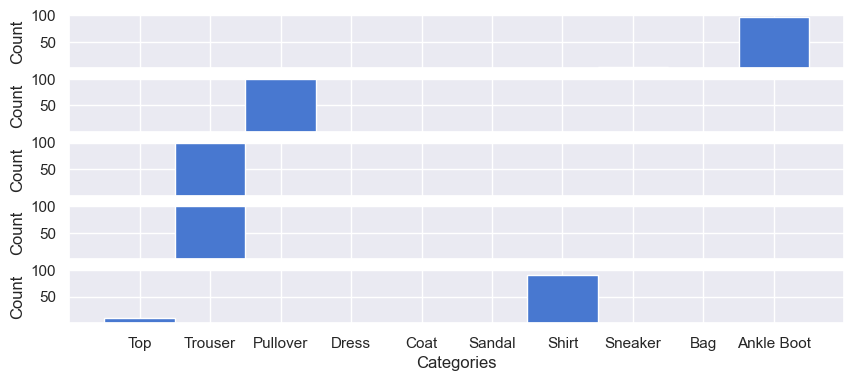

In [47]:
net.eval()
fmnist_outputs = net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    fmnist_outputs = np.append(fmnist_outputs, net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(fmnist_outputs[i], np.arange(-0.5, 10, 1))

#### Interpretation of Plots Above

The figure above presents histograms of predicted class frequencies for five test images, each evaluated across 100 stochastic forward passes through the Bayesian network.

- Each horizontal subplot corresponds to a different test image.
- The x-axis shows the 10 FashionMNIST categories, while the y-axis counts how often each class was predicted.

#### 📊 Interpretation:
- All five histograms are **highly peaked**, meaning each image consistently yields the same predicted class across all 100 samples.
- This indicates that the model has **low epistemic uncertainty** for these in-domain inputs—it is confident in its predictions despite posterior sampling.
- For instance:
  - The first image is confidently predicted as **Ankle Boot**,
  - The second as **Pullover**,
  - The third as **Trouser**, and so on.

This behavior is expected for well-trained Bayesian models on in-distribution data and suggests stable predictive performance on familiar inputs.

#### Out-of-Domain Uncertainty

The block code below initializes a data loader for the **MNIST test set**, which is used as an **out-of-domain dataset** for a model trained on FashionMNIST:

In [48]:
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)

The MNIST dataset (handwritten digits) is semantically and visually different from the FashionMNIST classes used during training. By passing MNIST samples through the Bayesian model, we can assess its epistemic uncertainty on unfamiliar data. A well-calibrated Bayesian model should exhibit higher uncertainty on these inputs due to lack of prior exposure.


This block code below are intended to visualizing MNIST Inputs. It Retrieves a batch of 5 MNIST test images and moves them to the model’s device. The labels (e.g., tensor([7, 2, 1, 0, 4])) are printed for reference, though they are irrelevant for FashionMNIST classification. A visual grid of the 5 digit images is displayed to illustrate the semantic domain gap between training and test distributions.


tensor([7, 2, 1, 0, 4])


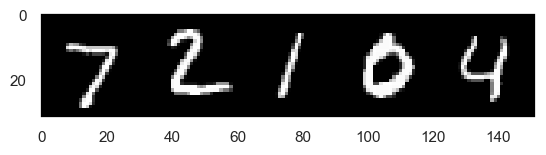

In [49]:
mnist_sample = next(iter(mnist_loader))
mnist_sample[0] = mnist_sample[0].to(DEVICE)
print(mnist_sample[1])
sns.set_style("dark")
show(make_grid(mnist_sample[0].cpu()))

The displayed image grid above shows five grayscale digit images from the MNIST test dataset, as retrieved and visualized by the code block.

- The tensor `tensor([7, 2, 1, 0, 4])` confirms that the true labels of the digits are 7, 2, 1, 0, and 4 respectively.
- These images are arranged horizontally using `make_grid` and rendered using `plt.imshow()` with the correct axis order and interpolation.
- The digit images have a consistent 28×28 resolution and black background, matching the expected MNIST format.

This visualization serves as the input reference for evaluating the Bayesian model's **epistemic uncertainty** on **out-of-domain** data (since the model was trained on FashionMNIST, not digits).

### Out-of-Domain Uncertainty Estimation on MNIST

This code performs 100 stochastic forward passes on a batch of MNIST digit images using the Bayesian neural network. Each prediction is recorded, and class frequencies are collected to form a 5×100 matrix of predicted FashionMNIST classes. Histograms are plotted for each image to visualize the distribution of predicted labels across the samples. A wide or multimodal distribution indicates high epistemic uncertainty, reflecting the model’s lack of confidence on unfamiliar (out-of-distribution) inputs.  
This approach helps evaluate how well the model can detect and express uncertainty when encountering data outside its training domain.

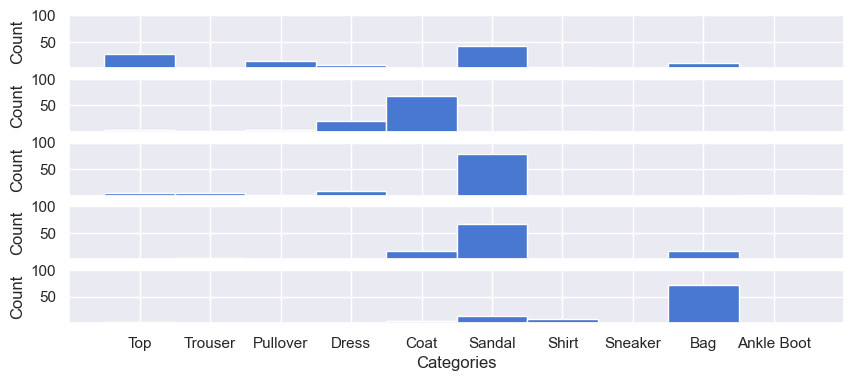

In [50]:
net.eval()
mnist_outputs = net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    mnist_outputs = np.append(mnist_outputs, net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)

sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(mnist_outputs[i], np.arange(-0.5, 10, 1))

The histogram plots above represent the predictive distributions of a Bayesian neural network (trained on FashionMNIST) when exposed to MNIST digit images as **out-of-distribution (OOD)** inputs.

- Each subplot corresponds to one MNIST image, showing the frequency of predicted FashionMNIST categories across 100 stochastic forward passes.
- Unlike in-domain samples which typically yield peaked distributions, these histograms are **spread out**, with predictions covering multiple classes.
- Some plots show **multimodal** or **uncertain** behavior (e.g., voting across Sandal, Bag, and Coat), indicating that the model lacks confidence in classifying these unfamiliar images.
- This wide dispersion is a desirable behavior—it reflects **epistemic uncertainty**, suggesting the model is aware it’s operating outside its training domain.

This confirms that the Bayesian model is behaving robustly by not overconfidently misclassifying OOD data, a key property in trustworthy machine learning systems.